In [146]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [147]:
n_hidden_channels = 12
n_total_channels = 4 + 2 + 1 + n_hidden_channels
alpha = 0.1
n_steps_per_frame = 10

In [148]:
def load_image(filename, threshold=-1):
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='rgba', target_size=(64, 64))
    img = np.array(img) / 255.0

    # add transparency channel for black pixels

    if not threshold == -1:
        img[img[:,:,0] < threshold] = [0, 0, 0, 0]
        img[img[:,:,0] >= threshold] = [1, 0, 0, 1]

    
    # add red border around the image
    #img[0, :, :] = [1, 0, 0, 1]
    #img[-1, :, :] = [1, 0, 0, 1]
    #img[:, 0, :] = [1, 0, 0, 1]
    #img[:, -1, :] = [1, 0, 0, 1]

    
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img = tf.expand_dims(img, 0)
    return img

def rgba(x):
    return x[0, :, :, :4]

def rgb(x):
  rgb, a = x[0, :, :, :3], tf.clip_by_value(x[0, :, :, 3:4], 0.0, 1.0)
  return 1.0-a+rgb

def plot(x):
    plt.imshow(rgb(x))
    plt.show()

def save_plot(x, filename):
    plt.imshow(rgb(x))
    plt.savefig('.\Imgs\Epoch ' + str(filename) + '.png')

def get_living_mask(x):
    channel_alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha

In [149]:
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1):
        #pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx# * tf.cast(update_mask, tf.float32)

        #post_life_mask = get_living_mask(x)
        #life_mask = pre_live_mask & post_life_mask
        return x#* tf.cast(life_mask, tf.float32)

In [150]:
model = NNA(n_total_channels)

In [151]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

In [152]:
velocity = []
dye = []
curl = []
anim_len = 300

for i in range(anim_len):
    velocity.append(load_image('../data/export/frame_vel_' + f'{i:05d}' + '.png'))
    dye.append(load_image('../data/export/frame_dye_' + f'{i:05d}' + '.png'))
    curl.append(load_image('../data/export/frame_curl_' + f'{i:05d}' + '.png'))

    

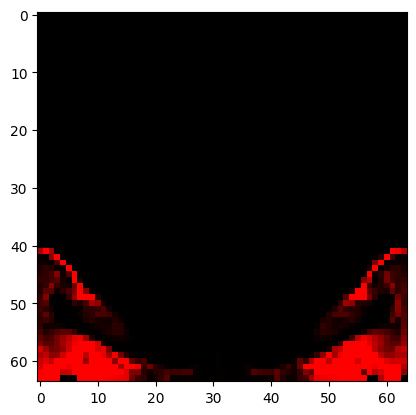

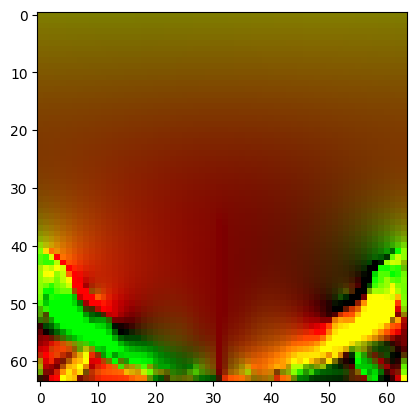

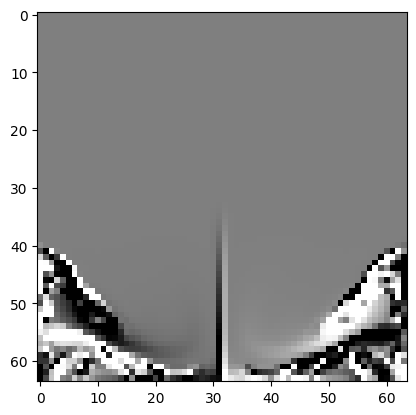

In [153]:
# dye is a 4d channel
plot(dye[int(anim_len*0.2)])
# velocity is a 2d channel
plot(velocity[int(anim_len*0.2)])
# curl is a 1d channel
plot(curl[int(anim_len*0.2)])

In [154]:
def init_image(step):
    img = np.zeros((64, 64 , n_total_channels), dtype=np.float32)
    img[:, :, :4] = rgba(dye[step])
    img[:, :, 4:6] = rgba(velocity[step])[:, :, :2]
    img[:, :, 6:7] = rgba(curl[step])[:, :, :1]
    img = tf.expand_dims(img, 0)
    return img

In [157]:
def loss_f(i, x):
    return loss_object(rgba(dye[i]), rgba(x))

def train(iterations, max_oracle_steps=10):
    # pick a random frame from the animation and try to predict it
    n = np.random.randint(0,anim_len-max_oracle_steps,size=iterations)
    steps = np.random.randint(1, max_oracle_steps, size=iterations)

    for j in range(iterations):
        i = n[j]
        n_steps = steps[j]

        x = init_image(i)

        # used to track the loss
        with tf.GradientTape() as g:
            for _ in range(n_steps_per_frame):
                x  = model(x, 1)
            # loss is computed with the difference between the current frame and the next frame
            loss = loss_f(i+n_steps, x) * 100

        # not necessary with single timestep variant

        gradients = g.gradient(loss, model.weights)
        gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
        optimizer.apply_gradients(zip(gradients, model.weights))

        if j % 10 == 0:
            f, axs = plt.subplots(1, 3)
            template = 'Epoch {}, Loss: {}'
            print(template.format(j + 1, loss))
            axs[0].imshow(rgb(dye[i]))
            axs[1].imshow(rgb(x))
            axs[2].imshow(rgb(dye[i + n_steps]))
            plt.show()
                
    return x, loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1, Loss: 0.017996329814195633


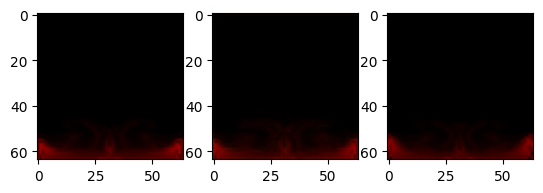

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 11, Loss: 0.008320032618939877


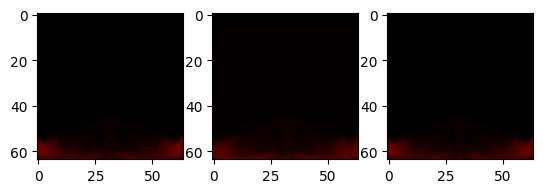

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 21, Loss: 0.003222702071070671


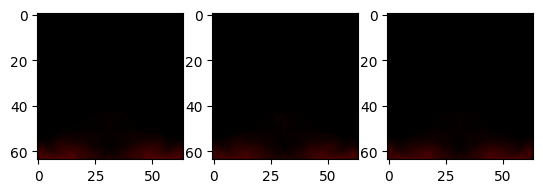

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 31, Loss: 0.3735727071762085


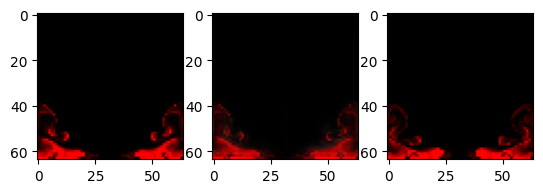

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 41, Loss: 0.0029819875489920378


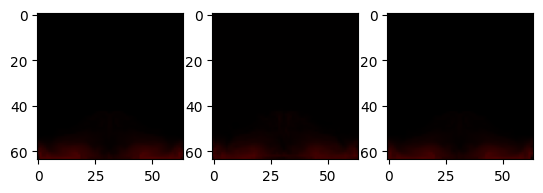

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 51, Loss: 0.02434244379401207


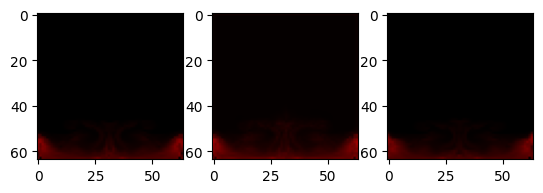

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 61, Loss: 0.0008762157522141933


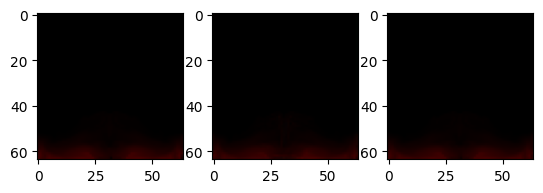

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 71, Loss: 0.1416415423154831


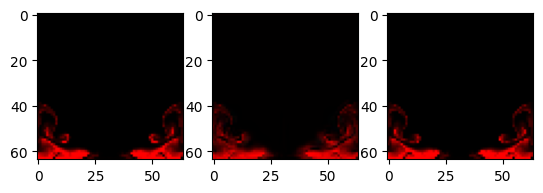

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 81, Loss: 0.5228343605995178


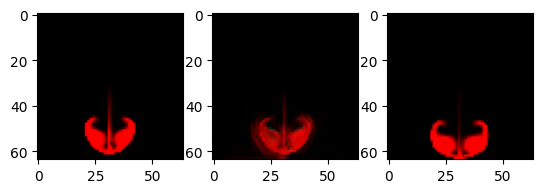

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 91, Loss: 0.4500619173049927


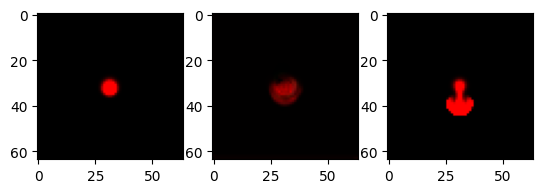

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 101, Loss: 0.6273279786109924


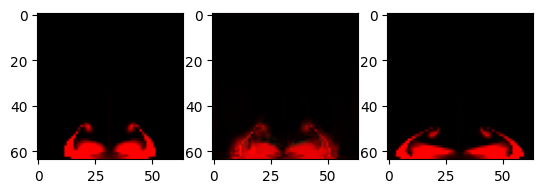

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 111, Loss: 0.4161505103111267


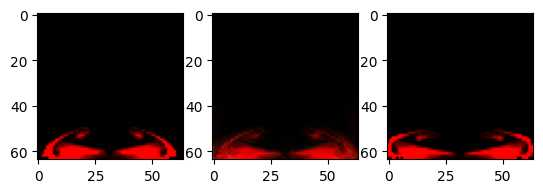

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 121, Loss: 0.004870614502578974


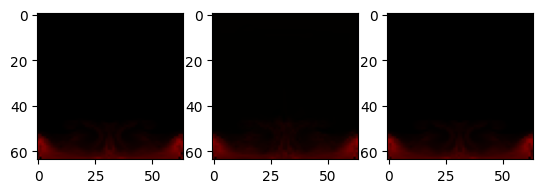

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 131, Loss: 0.5244009494781494


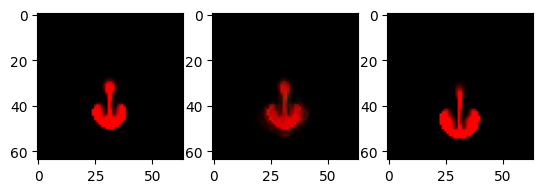

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 141, Loss: 0.0007194126374088228


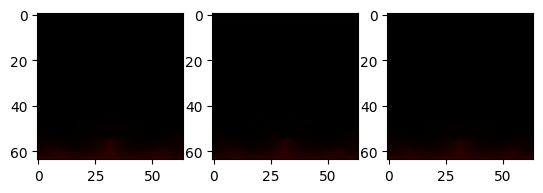

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 151, Loss: 0.0014577448600903153


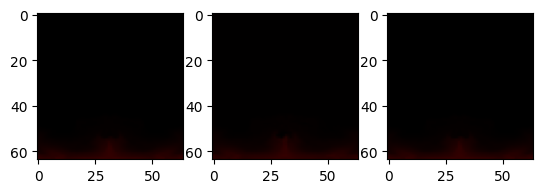

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 161, Loss: 0.02240413799881935


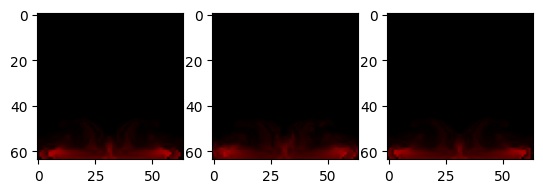

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 171, Loss: 0.003490958595648408


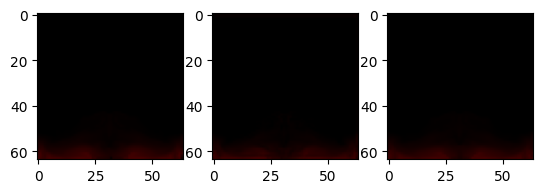

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 181, Loss: 0.002856423147022724


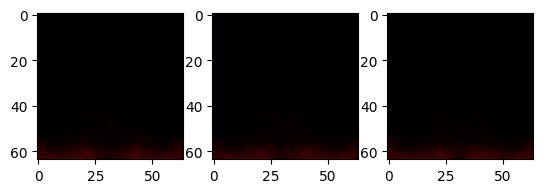

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 191, Loss: 0.0010248622857034206


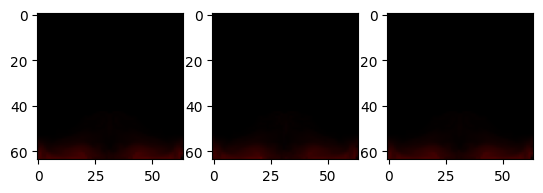

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 201, Loss: 0.0005611588130705059


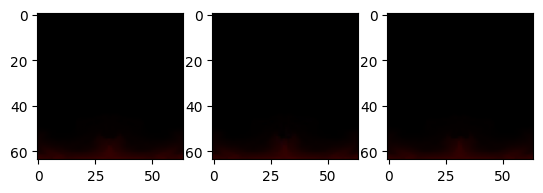

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 211, Loss: 0.00869409553706646


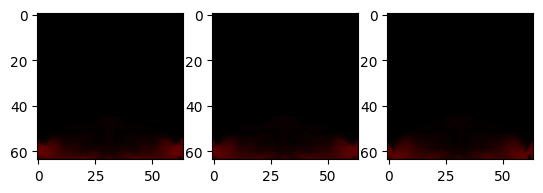

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 221, Loss: 0.0010367686627432704


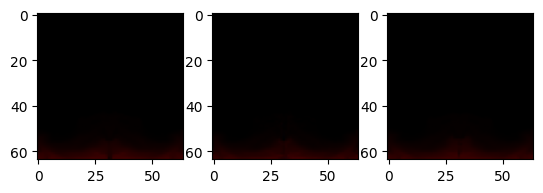

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 231, Loss: 0.058005448430776596


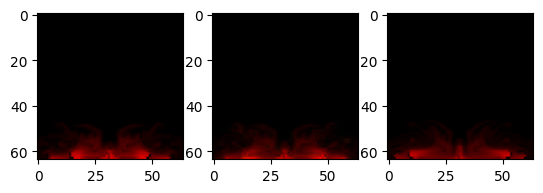

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 241, Loss: 0.17560993134975433


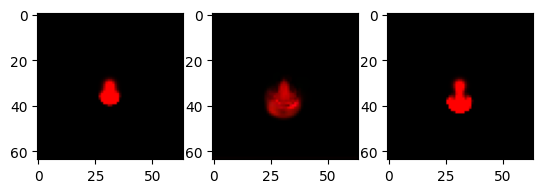

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 251, Loss: 0.004983651451766491


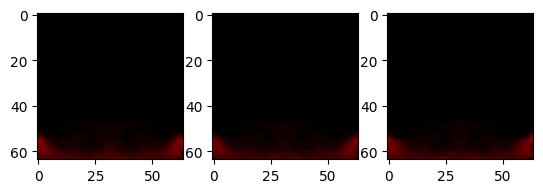

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 261, Loss: 0.11274570226669312


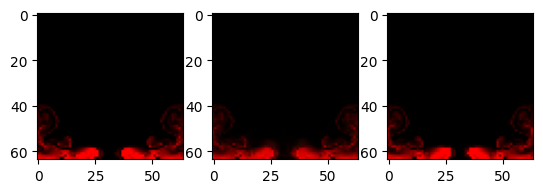

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 271, Loss: 0.003193673910573125


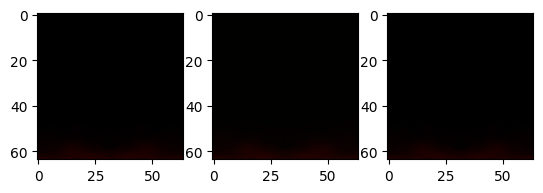

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 281, Loss: 0.005920667666941881


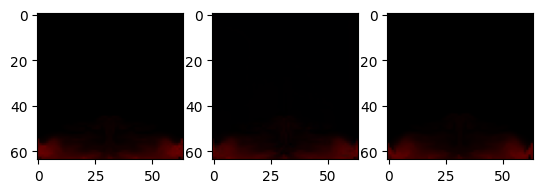

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 291, Loss: 0.0015766570577397943


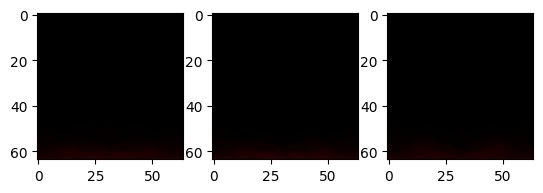

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 301, Loss: 0.009698116220533848


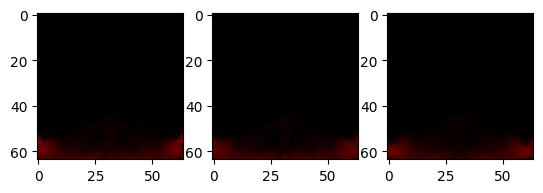

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 311, Loss: 0.16618412733078003


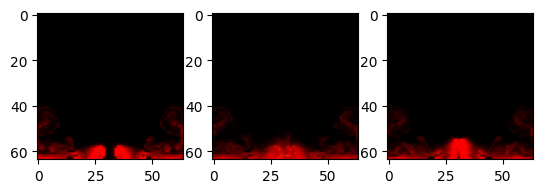

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 321, Loss: 0.006524770986288786


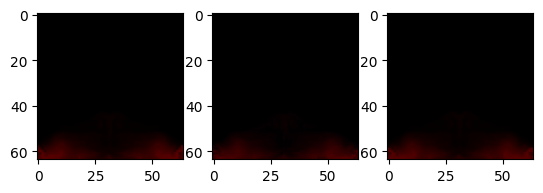

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 331, Loss: 0.33820247650146484


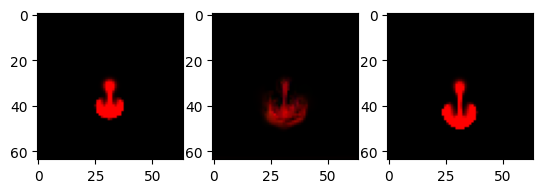

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 341, Loss: 0.04411837086081505


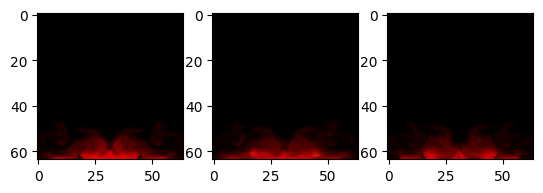

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 351, Loss: 0.005876731127500534


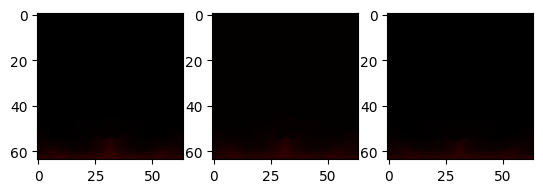

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 361, Loss: 0.26648321747779846


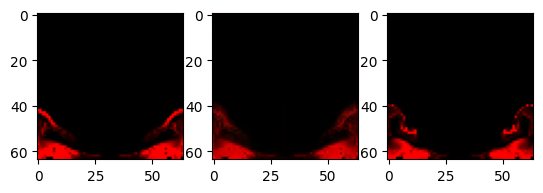

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 371, Loss: 0.07582372426986694


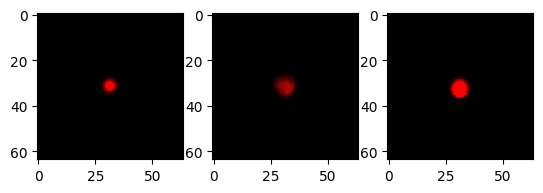

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 381, Loss: 0.035047776997089386


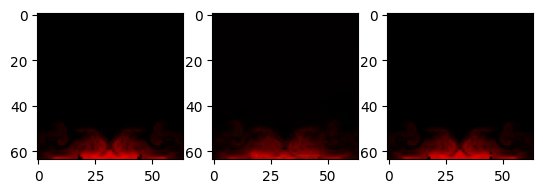

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 391, Loss: 0.00310581736266613


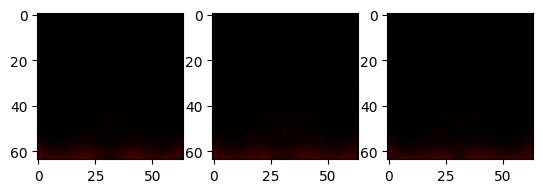

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 401, Loss: 0.009850304573774338


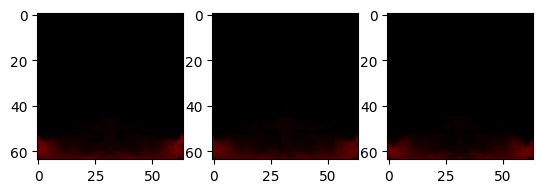

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 411, Loss: 0.31204453110694885


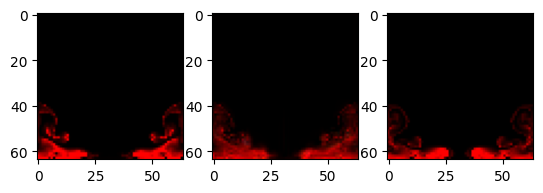

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 421, Loss: 0.8982735872268677


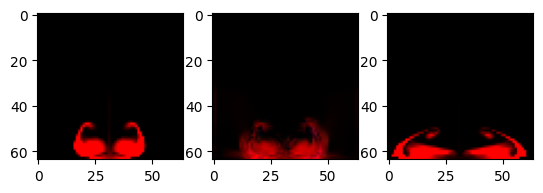

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 431, Loss: 0.0043305824510753155


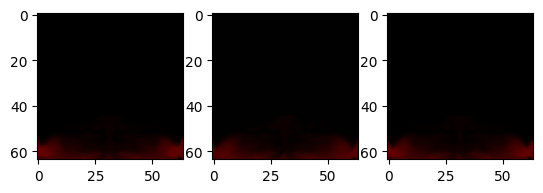

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 441, Loss: 0.23997890949249268


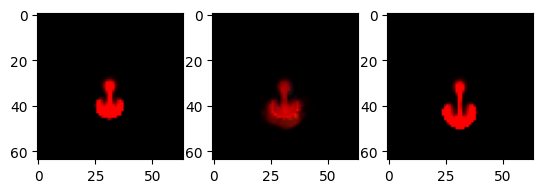

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 451, Loss: 0.0007677792455069721


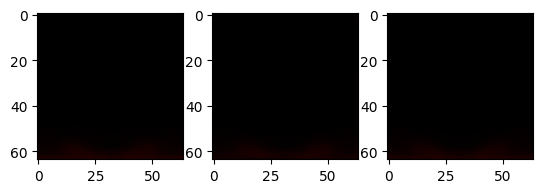

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 461, Loss: 0.0007567211287096143


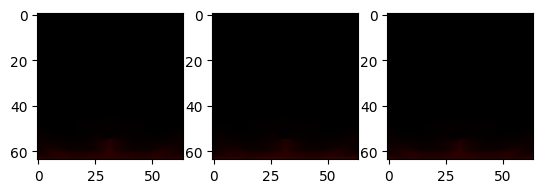

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 471, Loss: 0.005998955573886633


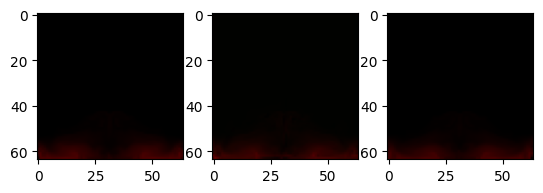

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 481, Loss: 0.6392602324485779


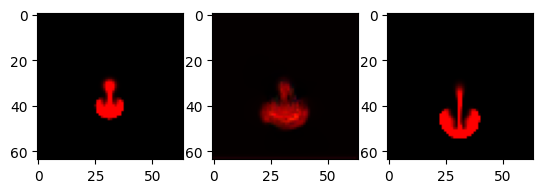

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 491, Loss: 0.1492951512336731


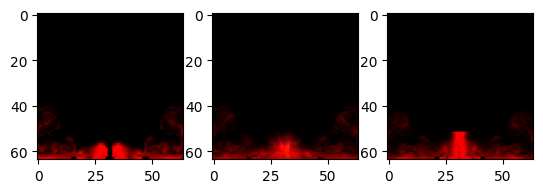

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 501, Loss: 0.01659185253083706


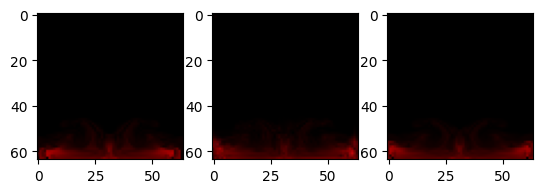

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 511, Loss: 0.033107511699199677


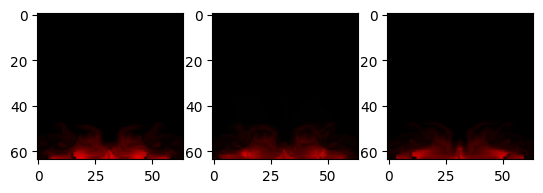

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 521, Loss: 0.0015727017307654023


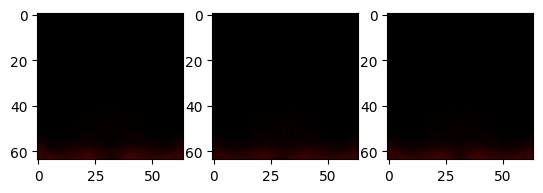

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 531, Loss: 0.032924115657806396


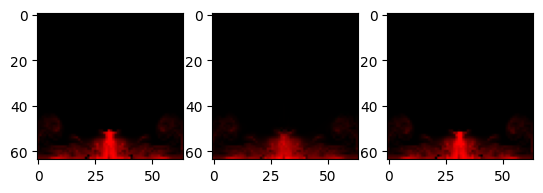

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 541, Loss: 0.06445929408073425


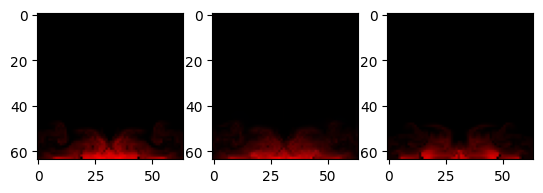

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 551, Loss: 0.1880861073732376


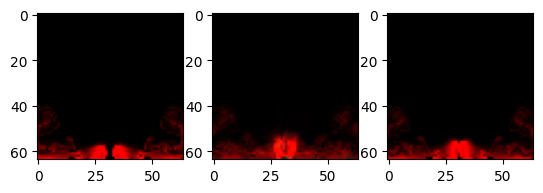

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 561, Loss: 0.0014473464107140899


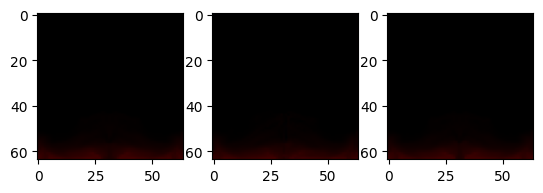

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 571, Loss: 0.003095909021794796


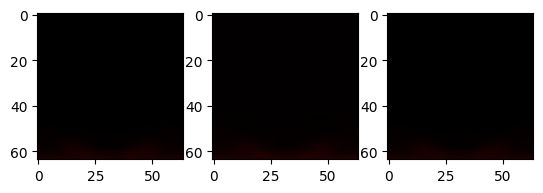

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 581, Loss: 0.008418426848948002


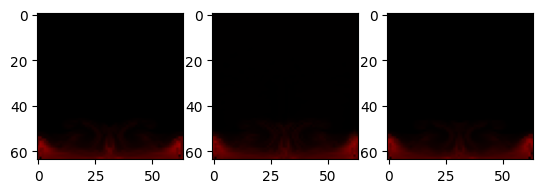

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 591, Loss: 0.0010278770932927728


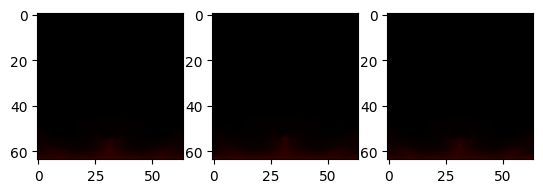

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 601, Loss: 0.0008510504849255085


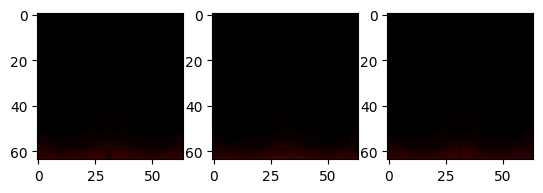

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 611, Loss: 0.0032119336538016796


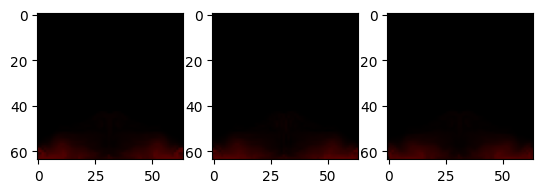

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 621, Loss: 0.6285281777381897


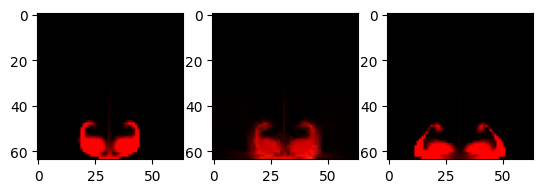

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 631, Loss: 0.0034532821737229824


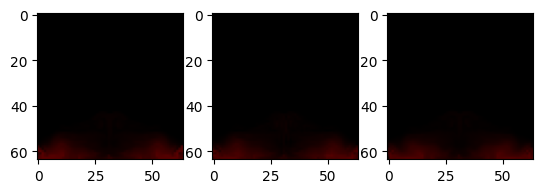

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 641, Loss: 0.0018169269897043705


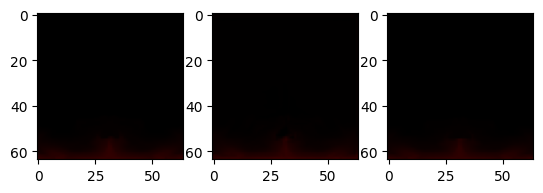

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 651, Loss: 0.04395534098148346


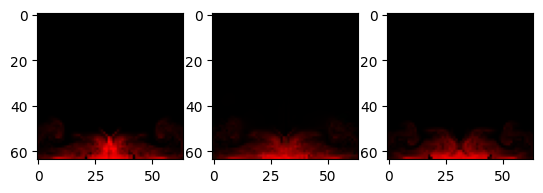

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 661, Loss: 0.0017484530108049512


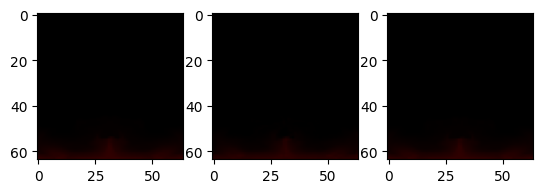

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 671, Loss: 0.002023017266765237


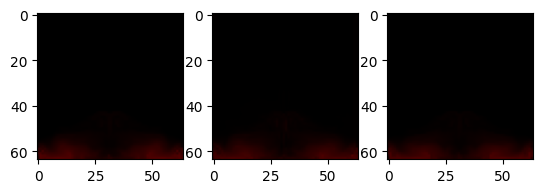

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 681, Loss: 0.04373769462108612


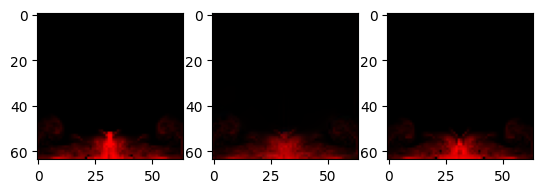

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 691, Loss: 0.07930146157741547


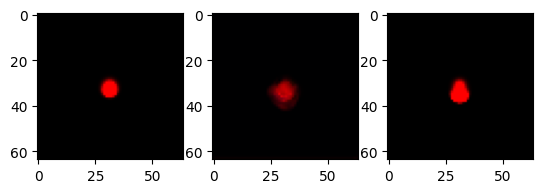

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 701, Loss: 0.0005579980788752437


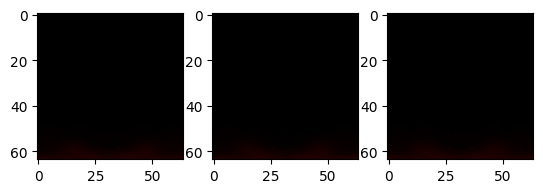

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 711, Loss: 0.015627030283212662


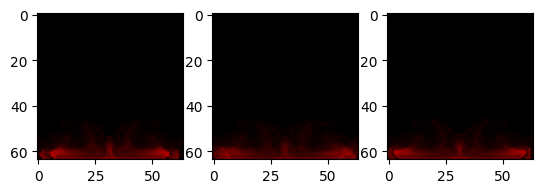

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 721, Loss: 0.0034359931014478207


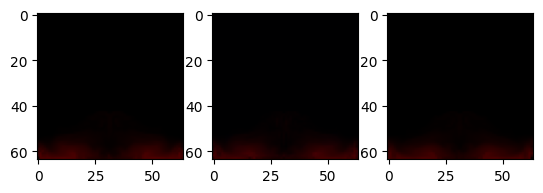

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 731, Loss: 0.00193710473831743


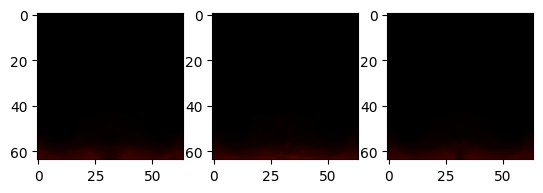

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 741, Loss: 0.0018043365562334657


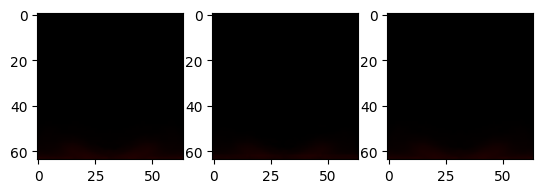

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 751, Loss: 0.002373825991526246


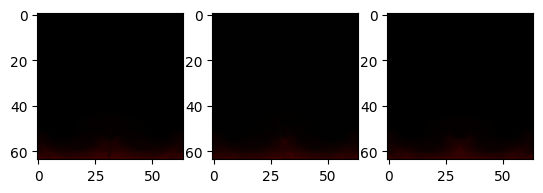

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 761, Loss: 0.0006770960171706975


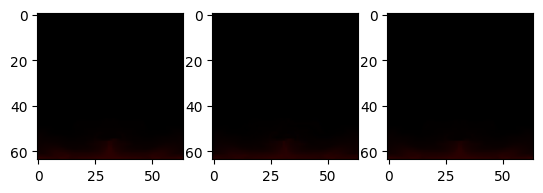

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 771, Loss: 0.0030309432186186314


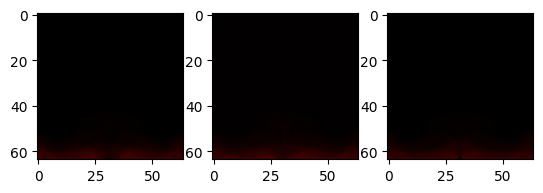

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 781, Loss: 0.0006397999823093414


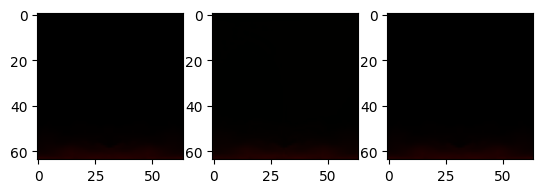

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 791, Loss: 0.02276589907705784


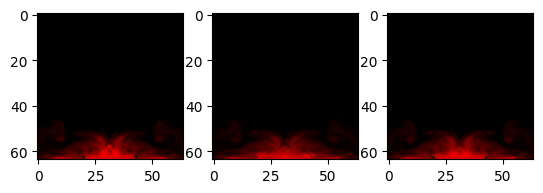

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 801, Loss: 0.08515778183937073


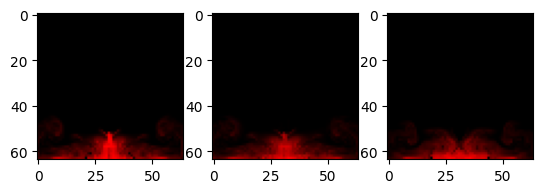

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 811, Loss: 0.03910535201430321


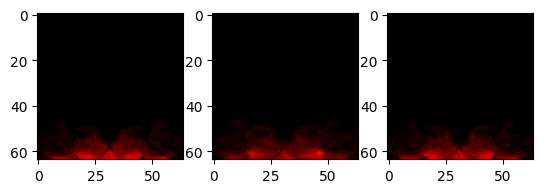

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 821, Loss: 0.008486959151923656


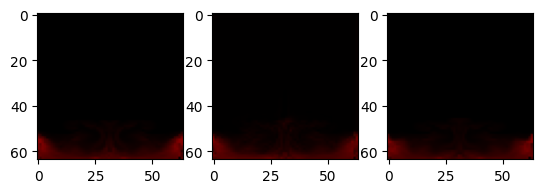

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 831, Loss: 0.003099182154983282


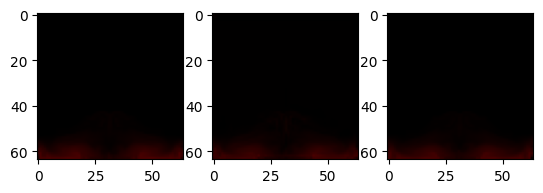

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 841, Loss: 0.007235449273139238


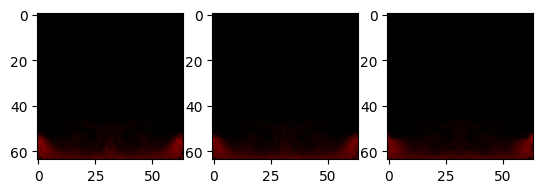

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 851, Loss: 0.00033740830258466303


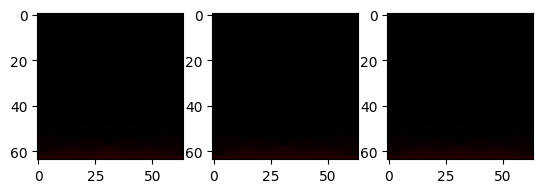

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 861, Loss: 0.15573573112487793


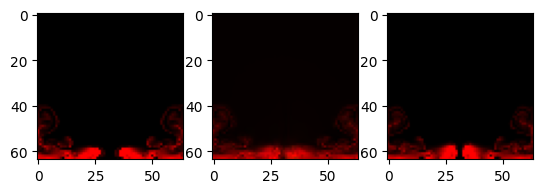

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 871, Loss: 0.006595917511731386


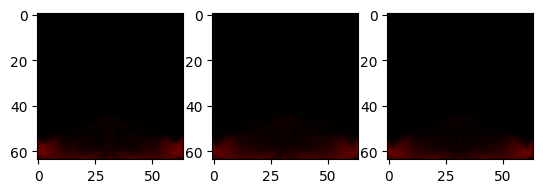

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 881, Loss: 0.0023247110657393932


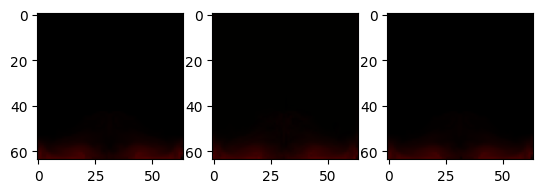

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 891, Loss: 0.0035264696925878525


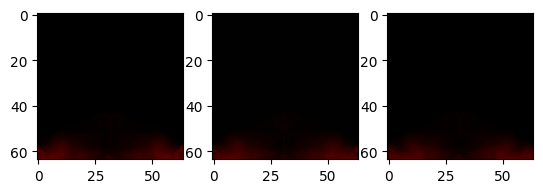

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 901, Loss: 0.0016096848994493484


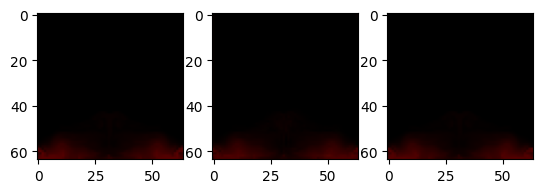

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 911, Loss: 0.026652732864022255


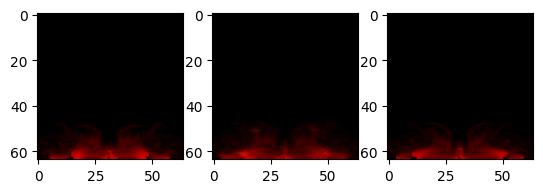

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 921, Loss: 0.005324097350239754


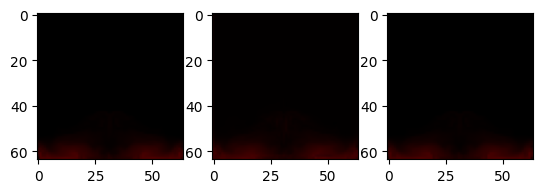

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 931, Loss: 0.005198290571570396


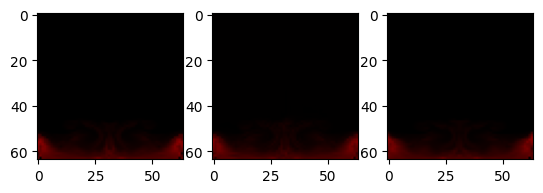

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 941, Loss: 0.0379711277782917


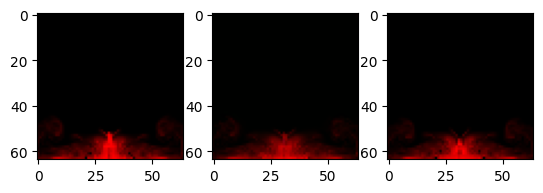

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 951, Loss: 0.24007418751716614


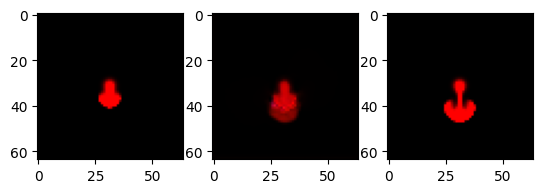

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 961, Loss: 0.003653906285762787


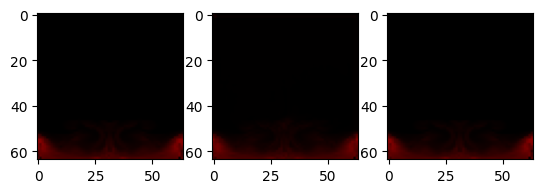

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 971, Loss: 0.15135504305362701


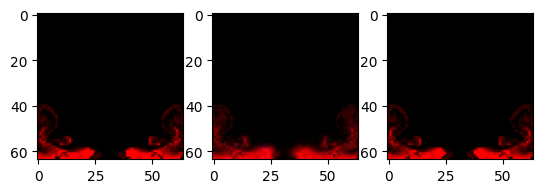

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 981, Loss: 0.001062097609974444


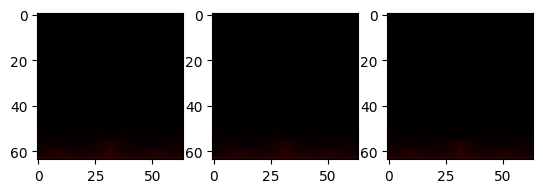

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 991, Loss: 0.04102424904704094


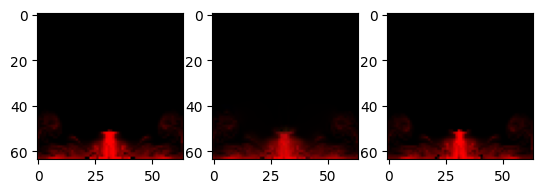

(<tf.Tensor: shape=(1, 64, 64, 19), dtype=float32, numpy=
 array([[[[ 6.5588765e-04, -1.3105765e-02,  7.8158267e-03, ...,
           -4.0379629e-01,  9.2906904e-01,  1.1709471e+00],
          [-2.7939174e-03, -5.8316570e-03,  4.4775424e-03, ...,
           -4.2308605e-01,  9.9574912e-01,  1.1992785e+00],
          [-4.6785921e-03, -5.8853077e-03,  4.4816989e-03, ...,
           -4.1343349e-01,  1.0048151e+00,  1.2019110e+00],
          ...,
          [-2.6360918e-03, -5.7759015e-03,  4.3406780e-03, ...,
           -4.1243124e-01,  1.0015858e+00,  1.1978868e+00],
          [-5.0090104e-03, -4.7282092e-03,  4.7857654e-03, ...,
           -4.3756407e-01,  9.9789536e-01,  1.2139376e+00],
          [ 9.2791766e-04, -1.3819026e-02,  6.7032268e-03, ...,
           -4.4474757e-01,  1.0317155e+00,  1.3175828e+00]],
 
         [[ 1.0700393e-02, -8.2255434e-03,  3.3944591e-03, ...,
           -3.4725252e-01,  6.9858223e-01,  1.0012898e+00],
          [ 1.0699175e-02, -3.3543021e-03,  2.0654958e-0

In [158]:
train(1000)

In [159]:
model.save("testModel")

INFO:tensorflow:Assets written to: testModel/assets


INFO:tensorflow:Assets written to: testModel/assets


In [175]:

from IPython import display
import pylab as pl
import time

def predict(init, iterations):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    x = init
    imgplot = plt.imshow(rgb(init))
    for i in range(iterations): 
        x = model(x, 1)
        imgplot.set_data(rgb(x))
        fig.canvas.draw()
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.1)

KeyboardInterrupt: 

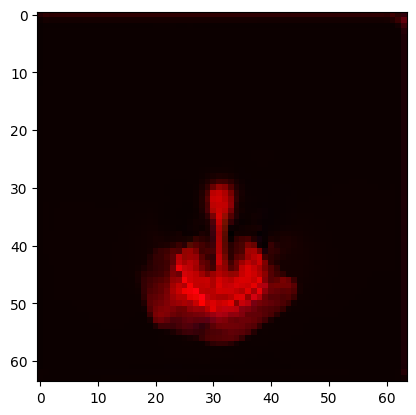

In [178]:
predict(init_image(20), 100)

In [15]:
#@title TensorFlow.js Demo {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running cells from the "Training" section of this notebook
import IPython.display

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model)

display(IPython.display.Javascript(data_js))

IPython.display.HTML('''
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.3.0/dist/tf.min.js"></script>

<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>

<script>
  "use strict";
  
  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));

  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        // if there is a 0-length dimension, the exported graph json lacks "size"
        const shape = v.tensorShape.dim.map(d=>(!d.size) ? 0 : parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          if (size) {
            arr.fill(v[field][0]);
          }
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  const run = async ()=>{
    const r = await fetch(GRAPH_URL);
    const consts = parseConsts(await r.json());
    
    const model = await tf.loadGraphModel(GRAPH_URL);
    Object.assign(model.weights, consts);
    
    let seed = new Array(16).fill(0).map((x, i)=>i<3?0:1);
    seed = tf.tensor(seed, [1, 1, 1, 16]);
    
    const D = 96;
    const initState = tf.tidy(()=>{
      const D2 = D/2;
      const a = seed.pad([[0, 0], [D2-1, D2], [D2-1, D2], [0,0]]);
      return a;
    });
    
    const state = tf.variable(initState);
    const [_, h, w, ch] = state.shape;
    
    const damage = (x, y, r)=>{
      tf.tidy(()=>{
        const rx = tf.range(0, w).sub(x).div(r).square().expandDims(0);
        const ry = tf.range(0, h).sub(y).div(r).square().expandDims(1);
        const mask = rx.add(ry).greater(1.0).expandDims(2);
        state.assign(state.mul(mask));
      });
    }
    
    const plantSeed = (x, y)=>{
      const x2 = w-x-seed.shape[2];
      const y2 = h-y-seed.shape[1];
      if (x<0 || x2<0 || y2<0 || y2<0)
        return;
      tf.tidy(()=>{
        const a = seed.pad([[0, 0], [y, y2], [x, x2], [0,0]]);
        state.assign(state.add(a));
      });
    }
    
    const scale = 4;
    
    const canvas = document.getElementById('canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = w;
    canvas.height = h;
    canvas.style.width = `${w*scale}px`;
    canvas.style.height = `${h*scale}px`;
    
    canvas.onmousedown = e=>{
      const x = Math.floor(e.clientX/scale);
        const y = Math.floor(e.clientY/scale);
        if (e.buttons == 1) {
          if (e.shiftKey) {
            plantSeed(x, y);  
          } else {
            damage(x, y, 8);
          }
        }
    }
    canvas.onmousemove = e=>{
      const x = Math.floor(e.clientX/scale);
      const y = Math.floor(e.clientY/scale);
      if (e.buttons == 1 && !e.shiftKey) {
        damage(x, y, 8);
      }
    }

    function step() {
      tf.tidy(()=>{
        state.assign(model.execute(
            {x:state, fire_rate:tf.tensor(0.5),
            angle:tf.tensor(0.0), step_size:tf.tensor(1.0)}, ['Identity']));
      });
    }

    function render() {
      step();

      const imageData = tf.tidy(()=>{
        const rgba = state.slice([0, 0, 0, 0], [-1, -1, -1, 4]);
        const a = state.slice([0, 0, 0, 3], [-1, -1, -1, 1]);
        const img = tf.tensor(1.0).sub(a).add(rgba).mul(255);
        const rgbaBytes = new Uint8ClampedArray(img.dataSync());
        return new ImageData(rgbaBytes, w, h);
      });
      ctx.putImageData(imageData, 0, 0);

      requestAnimationFrame(render);
    }
    render();
  }
  run();
  
</script>
''')

<IPython.core.display.Javascript object>